# 用户分组训练与留出评估版 TDM Notebook
本 notebook 用于：将部分用户作为训练集，其余用户留出做评估；数据按时间划分，强信号行为训练；包含训练、时间评估、beam search 推理与可视化。

In [20]:
# 1) 环境与依赖导入
import os
import random
import time
from collections import Counter, defaultdict
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# 设备设置与随机种子
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# 路径配置
DATA_PATH = 'user_shards/shard_00.csv'  # 使用 1/10 分片作为全量数据集
MODEL_DIR = 'sampled_data'
os.makedirs(MODEL_DIR, exist_ok=True)

device: cuda
NVIDIA GeForce RTX 4060 Laptop GPU


In [21]:
# 2) 加载强信号数据与用户分组
POSITIVE_BEHAVIORS = ['buy', 'cart', 'fav']
user_eval_frac = 0.10  # 留出10%用户做评估

df = pd.read_csv(DATA_PATH, header=0)
df.columns = ['user_id', 'item_id', 'category_id', 'behavior', 'timestamp'][: len(df.columns)]

print(f"Loaded {len(df):,} rows from {DATA_PATH}")

# 只保留强信号
strong_df = df[df['behavior'].isin(POSITIVE_BEHAVIORS)].copy()
strong_df = strong_df.sort_values('timestamp')
print(f"Strong signals: {len(strong_df):,} rows ({len(strong_df)/len(df)*100:.1f}%)")

# 用户分组：训练用户 / 留出评估用户（不做时间分割，因为数据跨度太短）
all_users = strong_df['user_id'].unique()
rng = np.random.default_rng(SEED)
rng.shuffle(all_users)
split_users = int(len(all_users) * (1 - user_eval_frac))
train_users = set(all_users[:split_users])
eval_users = set(all_users[split_users:])

train_core = strong_df[strong_df.user_id.isin(train_users)].copy()
eval_core_df = strong_df[strong_df.user_id.isin(eval_users)].copy()

print(f"Train users: {len(train_users):,}, Eval users: {len(eval_users):,}")
print(f"Train data: {len(train_core):,} rows, Eval data: {len(eval_core_df):,} rows")

# 过滤训练集中少于2条行为的用户
user_counts = train_core['user_id'].value_counts()
active_users = set(user_counts[user_counts >= 2].index)
train_core = train_core[train_core.user_id.isin(active_users)].copy()

print(f"Active train users (>= 2 events): {len(active_users):,}")
print(f"Final train core: {len(train_core):,} rows from {train_core.user_id.nunique():,} users")

# 为评估用户构建核心数据（全部历史用于推理）
eval_core = []
for uid in eval_core_df['user_id'].unique():
    g = eval_core_df[eval_core_df.user_id == uid]
    if len(g) >= 2:  # 至少2条行为
        eval_core.append({'user_id': uid, 'items': g['item_id'].tolist()})

print(f"Eval users usable (>= 2 events): {len(eval_core):,}")

Loaded 9,980,306 rows from user_shards/shard_00.csv
Strong signals: 1,042,186 rows (10.4%)
Train users: 83,643, Eval users: 9,294
Train data: 936,501 rows, Eval data: 105,685 rows
Active train users (>= 2 events): 77,242
Final train core: 930,100 rows from 77,242 users
Eval users usable (>= 2 events): 8,607


In [22]:
# 3) ID 映射与物品-类目表构建（基于训练核心集）
unique_items = train_core['item_id'].unique()
unique_cats = train_core['category_id'].unique()

item2id = {iid: i for i, iid in enumerate(unique_items, start=1)}
id2item = {v: k for k, v in item2id.items()}
cat2id = {cid: i for i, cid in enumerate(unique_cats, start=1)}
id2cat = {v: k for k, v in cat2id.items()}

n_items = len(item2id)
n_cats = len(cat2id)
print(f"Items: {n_items:,}, Categories: {n_cats:,}")

# 物品 -> 类目映射表（训练集）
item_category_tbl = train_core.groupby('item_id')['category_id'].first().reset_index()
item_idx_to_cat_idx: Dict[int, int] = {}
for item_id, cat_id in zip(item_category_tbl['item_id'], item_category_tbl['category_id']):
    if item_id in item2id and cat_id in cat2id:
        item_idx_to_cat_idx[item2id[item_id]] = cat2id[cat_id]

# 类目 -> 物品索引列表
cat_idx_to_item_indices: Dict[int, List[int]] = {}
for item_idx, cat_idx in item_idx_to_cat_idx.items():
    cat_idx_to_item_indices.setdefault(cat_idx, []).append(item_idx)

print(f"Item->Cat mappings: {len(item_idx_to_cat_idx):,}")
print(f"Cat->Items buckets: {len(cat_idx_to_item_indices):,}")

Items: 419,235, Categories: 6,228
Item->Cat mappings: 419,235
Cat->Items buckets: 6,228


In [23]:
# 4) TDM 训练数据集与 DataLoader
class TDMDataset(Dataset):
    def __init__(self, df: pd.DataFrame, item2id: Dict[int, int], cat2id: Dict[int, int],
                 item_idx_to_cat_idx: Dict[int, int], seq_len: int = 50, neg_samples: int = 5):
        self.seq_len = seq_len
        self.neg_samples = neg_samples
        self.item2id = item2id
        self.cat2id = cat2id
        self.item_idx_to_cat_idx = item_idx_to_cat_idx
        self.all_cat_indices = list(cat2id.values())
        self.all_item_indices = list(item2id.values())

        # 类目 -> 物品索引列表
        self.cat_idx_to_item_indices: Dict[int, List[int]] = {}
        for item_idx, cat_idx in self.item_idx_to_cat_idx.items():
            self.cat_idx_to_item_indices.setdefault(cat_idx, []).append(item_idx)

        self.samples = self._build_samples(df)

    def _build_samples(self, df: pd.DataFrame):
        samples = []
        df_sorted = df.sort_values(['user_id', 'timestamp'])
        for uid, g in tqdm(df_sorted.groupby('user_id'), desc='build samples'):
            item_ids = g['item_id'].tolist()
            item_indices = [self.item2id[i] for i in item_ids if i in self.item2id]
            if len(item_indices) < 3:
                continue
            for i in range(2, len(item_indices)):
                hist = item_indices[max(0, i - self.seq_len):i]
                tgt_item = item_indices[i]
                if tgt_item not in self.item_idx_to_cat_idx:
                    continue
                tgt_cat = self.item_idx_to_cat_idx[tgt_item]
                samples.append({'history': hist, 'tgt_item': tgt_item, 'tgt_cat': tgt_cat})
        return samples

    def __len__(self):
        return len(self.samples)

    def _sample_neg_cats(self, pos_cat: int, k: int):
        neg = []
        while len(neg) < k:
            c = random.choice(self.all_cat_indices)
            if c != pos_cat and c not in neg:
                neg.append(c)
        return neg

    def _sample_neg_items(self, pos_item: int, cat_idx: int, k: int):
        neg = []
        bucket = self.cat_idx_to_item_indices.get(cat_idx, self.all_item_indices)
        attempts = 0
        while len(neg) < k and attempts < k * 3:
            item_idx = random.choice(bucket) if len(bucket) > 1 else random.choice(self.all_item_indices)
            if item_idx != pos_item and item_idx not in neg:
                neg.append(item_idx)
            attempts += 1
        while len(neg) < k:
            item_idx = random.choice(self.all_item_indices)
            if item_idx != pos_item and item_idx not in neg:
                neg.append(item_idx)
        return neg

    def __getitem__(self, idx):
        s = self.samples[idx]
        hist = s['history']
        if len(hist) < self.seq_len:
            hist = [0] * (self.seq_len - len(hist)) + hist
        else:
            hist = hist[-self.seq_len:]
        pos_item = s['tgt_item']
        pos_cat = s['tgt_cat']
        neg_cats = self._sample_neg_cats(pos_cat, self.neg_samples)
        neg_items = self._sample_neg_items(pos_item, pos_cat, self.neg_samples)
        return {
            'history': torch.LongTensor(hist),
            'pos_item': torch.LongTensor([pos_item]),
            'pos_cat': torch.LongTensor([pos_cat]),
            'neg_items': torch.LongTensor(neg_items),
            'neg_cats': torch.LongTensor(neg_cats)
        }

dataset = TDMDataset(train_core, item2id, cat2id, item_idx_to_cat_idx, seq_len=50, neg_samples=5)
train_loader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)
print(f"Samples: {len(dataset):,}, Batches: {len(train_loader):,}")

build samples: 100%|██████████| 77242/77242 [00:05<00:00, 13957.68it/s]


Samples: 775,616, Batches: 3,030


In [24]:
# 5) TDM 模型定义（层级分类）
class TDMModelWithTree(nn.Module):
    def __init__(self, n_items: int, n_cats: int, embed_dim: int = 64, hidden_dim: int = 128):
        super().__init__()
        self.item_embedding = nn.Embedding(n_items + 1, embed_dim, padding_idx=0)
        self.cat_embedding = nn.Embedding(n_cats + 1, embed_dim, padding_idx=0)
        self.user_encoder = nn.GRU(input_size=embed_dim, hidden_size=hidden_dim, num_layers=2, batch_first=True, dropout=0.2)
        self.cat_classifier = nn.Sequential(
            nn.Linear(hidden_dim + embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 1)
        )
        self.item_classifier = nn.Sequential(
            nn.Linear(hidden_dim + embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 1)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, mean=0, std=0.1)

    def encode_user(self, item_seq):
        embeds = self.item_embedding(item_seq)
        _, h = self.user_encoder(embeds)
        return h[-1]

    def predict_category(self, user_repr, cat_ids):
        cat_emb = self.cat_embedding(cat_ids)
        user_exp = user_repr.unsqueeze(1).expand(-1, cat_ids.shape[1], -1)
        logits = self.cat_classifier(torch.cat([user_exp, cat_emb], dim=-1)).squeeze(-1)
        return logits

    def predict_item(self, user_repr, item_ids):
        item_emb = self.item_embedding(item_ids)
        user_exp = user_repr.unsqueeze(1).expand(-1, item_ids.shape[1], -1)
        logits = self.item_classifier(torch.cat([user_exp, item_emb], dim=-1)).squeeze(-1)
        return logits

    def forward(self, history, pos_items, neg_items, pos_cats, neg_cats):
        user_repr = self.encode_user(history)
        all_cats = torch.cat([pos_cats, neg_cats], dim=1)
        cat_logits = self.predict_category(user_repr, all_cats)
        cat_labels = torch.zeros(cat_logits.shape[0], dtype=torch.long, device=cat_logits.device)
        cat_loss = F.cross_entropy(cat_logits, cat_labels)

        all_items = torch.cat([pos_items, neg_items], dim=1)
        item_logits = self.predict_item(user_repr, all_items)
        item_labels = torch.zeros(item_logits.shape[0], dtype=torch.long, device=item_logits.device)
        item_loss = F.cross_entropy(item_logits, item_labels)
        return cat_loss, item_loss

tdm_model = TDMModelWithTree(n_items, n_cats, embed_dim=64, hidden_dim=128).to(device)
print(tdm_model)

TDMModelWithTree(
  (item_embedding): Embedding(419236, 64, padding_idx=0)
  (cat_embedding): Embedding(6229, 64, padding_idx=0)
  (user_encoder): GRU(64, 128, num_layers=2, batch_first=True, dropout=0.2)
  (cat_classifier): Sequential(
    (0): Linear(in_features=192, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
  (item_classifier): Sequential(
    (0): Linear(in_features=192, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [25]:
# 6) 训练循环与模型保存
def train_epoch(model, loader, optimizer, device, epoch):
    model.train()
    tot_cat = tot_item = tot = 0.0
    steps = 0
    pbar = tqdm(loader, desc=f'Epoch {epoch}')
    for batch in pbar:
        history = batch['history'].to(device)
        pos_items = batch['pos_item'].to(device)
        neg_items = batch['neg_items'].to(device)
        pos_cats = batch['pos_cat'].to(device)
        neg_cats = batch['neg_cats'].to(device)

        optimizer.zero_grad()
        cat_loss, item_loss = model(history, pos_items, neg_items, pos_cats, neg_cats)
        loss = cat_loss * 0.3 + item_loss * 0.7
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        tot_cat += cat_loss.item()
        tot_item += item_loss.item()
        tot += loss.item()
        steps += 1
        pbar.set_postfix(loss=f'{loss.item():.4f}', cat=f'{cat_loss.item():.4f}', item=f'{item_loss.item():.4f}')
    return tot / steps, tot_cat / steps, tot_item / steps

optimizer = torch.optim.Adam(tdm_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

num_epochs = 3  # 可酌情增加
best_loss = float('inf')
history_losses = []

print('=' * 60)
print('Start training (user-holdout + time split)')
print('=' * 60)

for epoch in range(1, num_epochs + 1):
    avg_loss, avg_cat, avg_item = train_epoch(tdm_model, train_loader, optimizer, device, epoch)
    scheduler.step()
    history_losses.append({'epoch': epoch, 'loss': avg_loss, 'cat_loss': avg_cat, 'item_loss': avg_item})
    print(f"Epoch {epoch}: loss={avg_loss:.4f} cat={avg_cat:.4f} item={avg_item:.4f} lr={scheduler.get_last_lr()[0]:.5f}")
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({'epoch': epoch, 'model_state_dict': tdm_model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'loss': avg_loss}, os.path.join(MODEL_DIR, 'tdm_best_model_usersplit.pt'))
        print(f"  saved best checkpoint @ loss {best_loss:.4f}")

Start training (user-holdout + time split)


Epoch 1: 100%|██████████| 3030/3030 [02:15<00:00, 22.28it/s, cat=0.6207, item=1.4619, loss=1.2096]


Epoch 1: loss=1.2874 cat=0.5445 item=1.6058 lr=0.00100
  saved best checkpoint @ loss 1.2874


Epoch 2: 100%|██████████| 3030/3030 [02:28<00:00, 20.45it/s, cat=0.5286, item=1.4104, loss=1.1459]


Epoch 2: loss=1.0930 cat=0.5145 item=1.3409 lr=0.00050
  saved best checkpoint @ loss 1.0930


Epoch 3: 100%|██████████| 3030/3030 [02:18<00:00, 21.85it/s, cat=0.4161, item=0.8811, loss=0.7416]


Epoch 3: loss=0.7379 cat=0.4945 item=0.8422 lr=0.00050
  saved best checkpoint @ loss 0.7379


In [33]:
# (Helper) Beam Search，在评估前定义
@torch.no_grad()
def tdm_beam_search(model, user_history_indices: List[int], all_cat_indices: List[int], cat_idx_to_item_indices: Dict[int, List[int]], device, top_k_categories: int = 20, top_k_items: int = 10):
    model.eval()
    seq_len = 50
    hist = user_history_indices[-seq_len:]
    if len(hist) < seq_len:
        hist = [0] * (seq_len - len(hist)) + hist
    history_tensor = torch.LongTensor([hist]).to(device)
    user_repr = model.encode_user(history_tensor)

    cat_tensor = torch.LongTensor([all_cat_indices]).to(device)
    cat_logits = model.predict_category(user_repr, cat_tensor)
    cat_scores = torch.softmax(cat_logits, dim=-1).squeeze(0)
    top_cat_scores, top_cat_indices = torch.topk(cat_scores, min(top_k_categories, len(all_cat_indices)))
    top_categories = [(all_cat_indices[idx.item()], top_cat_scores[i].item()) for i, idx in enumerate(top_cat_indices)]

    candidates = []
    for cat_idx, cat_score in top_categories:
        if cat_idx not in cat_idx_to_item_indices:
            continue
        items_bucket = cat_idx_to_item_indices[cat_idx][:80]  # 限制每类物品数（优化速度）
        if not items_bucket:
            continue
        item_tensor = torch.LongTensor([items_bucket]).to(device)
        item_logits = model.predict_item(user_repr, item_tensor)
        item_scores = torch.softmax(item_logits, dim=-1).squeeze(0)
        for i, item_idx in enumerate(items_bucket):
            score = cat_score * 0.3 + item_scores[i].item() * 0.7
            candidates.append((item_idx, score))

    candidates.sort(key=lambda x: x[1], reverse=True)
    seen = set()
    uniq = []
    for item_idx, score in candidates:
        if item_idx in seen:
            continue
        seen.add(item_idx)
        uniq.append((item_idx, score))
        if len(uniq) >= top_k_items:
            break
    return uniq

In [35]:
# 7) 用户分组评估（用全部历史做推理与评估）
all_cat_indices = list(cat2id.values())

def evaluate_model_usersplit(model, eval_core: List[Dict], item2id, all_cat_indices, cat_idx_to_item_indices, device, k_list=[5, 10, 20]):
    """评估模型：用eval用户的全部行为作为推荐基准"""
    model.eval()
    metrics = defaultdict(list)
    for row in tqdm(eval_core, desc='eval users'):
        items = [iid for iid in row['items'] if iid in item2id]
        if len(items) < 2:
            continue
        hist_idx = [item2id[i] for i in items][-50:]
        gt_idx = set(item2id[i] for i in items)  # 全部行为作为ground truth
        max_k = max(k_list)
        recs = tdm_beam_search(model, hist_idx, all_cat_indices, cat_idx_to_item_indices, device, top_k_categories=15, top_k_items=max_k)
        rec_items = [i for i, _ in recs]
        for k in k_list:
            rec_k = rec_items[:k]
            hits = len(set(rec_k) & gt_idx)
            recall = hits / len(gt_idx) if gt_idx else 0
            hit_rate = 1 if hits > 0 else 0
            dcg = 0
            for idx, item in enumerate(rec_k):
                if item in gt_idx:
                    dcg += 1 / np.log2(idx + 2)
            ideal_dcg = sum(1 / np.log2(i + 2) for i in range(min(k, len(gt_idx))))
            ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0
            metrics[f'Recall@{k}'].append(recall)
            metrics[f'HitRate@{k}'].append(hit_rate)
            metrics[f'NDCG@{k}'].append(ndcg)
    return {m: float(np.mean(v)) if len(v) else 0.0 for m, v in metrics.items()}

# 采样评估（快速验证）：只评估前1500个用户
eval_sample_size = min(1500, len(eval_core))
print(f'\nEvaluating on {eval_sample_size}/{len(eval_core)} users (sampled for speed)...')
eval_results = evaluate_model_usersplit(tdm_model, eval_core[:eval_sample_size], item2id, all_cat_indices, cat_idx_to_item_indices, device)

print('\nEval (holdout users, full history - sampled)')
for k in [5, 10, 20]:
    print(f"Recall@{k}: {eval_results.get(f'Recall@{k}', 0):.4f} | HitRate@{k}: {eval_results.get(f'HitRate@{k}', 0):.4f} | NDCG@{k}: {eval_results.get(f'NDCG@{k}', 0):.4f}")


Evaluating on 1500/8607 users (sampled for speed)...


eval users: 100%|██████████| 1500/1500 [01:11<00:00, 21.09it/s]


Eval (holdout users, full history - sampled)
Recall@5: 0.0006 | HitRate@5: 0.0091 | NDCG@5: 0.0020
Recall@10: 0.0010 | HitRate@10: 0.0119 | NDCG@10: 0.0016
Recall@20: 0.0013 | HitRate@20: 0.0147 | NDCG@20: 0.0015


In [38]:
# 7.5) 训练集用户评估（验证模型是否学到了训练用户的偏好）
print('\n' + '='*60)
print('评估训练集用户（sanity check）')
print('='*60)

# 从训练集用户中构建评估数据
train_eval_core = []
for uid in train_core['user_id'].unique()[:1500]:  # 取前1500个训练用户
    g = train_core[train_core.user_id == uid]
    if len(g) >= 2:
        train_eval_core.append({'user_id': uid, 'items': g['item_id'].tolist()})

print(f'Testing on {len(train_eval_core)} training users...')
train_eval_results = evaluate_model_usersplit(tdm_model, train_eval_core, item2id, all_cat_indices, cat_idx_to_item_indices, device)

print('\nEval on TRAINING users (should be high if model learned):')
for k in [5, 10, 20]:
    print(f"Recall@{k}: {train_eval_results.get(f'Recall@{k}', 0):.4f} | HitRate@{k}: {train_eval_results.get(f'HitRate@{k}', 0):.4f} | NDCG@{k}: {train_eval_results.get(f'NDCG@{k}', 0):.4f}")

print('\n对比：')
print('训练用户 vs 留出用户的指标差异 → 判断是模型问题还是泛化问题')


评估训练集用户（sanity check）
Testing on 1500 training users...


eval users: 100%|██████████| 1500/1500 [01:17<00:00, 19.37it/s]


Eval on TRAINING users (should be high if model learned):
Recall@5: 0.0003 | HitRate@5: 0.0073 | NDCG@5: 0.0018
Recall@10: 0.0004 | HitRate@10: 0.0093 | NDCG@10: 0.0013
Recall@20: 0.0006 | HitRate@20: 0.0140 | NDCG@20: 0.0011

对比：
训练用户 vs 留出用户的指标差异 → 判断是模型问题还是泛化问题


In [ ]:
# 7.6) Leave-One-Out 评估（正确的评估方式）
print('\n' + '='*60)
print('Leave-One-Out 评估（与训练目标一致）')
print('='*60)

def evaluate_leave_one_out(model, eval_core: List[Dict], item2id, all_cat_indices, cat_idx_to_item_indices, device, k_list=[5, 10, 20]):
    """
    正确的评估方式：用前N-1个物品预测第N个物品
    与训练时的任务一致：序列预测下一个物品
    """
    model.eval()
    metrics = defaultdict(list)
    
    for row in tqdm(eval_core, desc='leave-one-out eval'):
        items = [iid for iid in row['items'] if iid in item2id]
        if len(items) < 3:  # 至少需要2个历史+1个目标
            continue
        
        item_indices = [item2id[i] for i in items]
        
        # 用前N-1个预测最后1个
        hist_idx = item_indices[:-1][-50:]  # 最近50个作为历史
        target_item = item_indices[-1]  # 最后1个作为目标
        
        max_k = max(k_list)
        recs = tdm_beam_search(model, hist_idx, all_cat_indices, cat_idx_to_item_indices, device, top_k_categories=15, top_k_items=max_k)
        rec_items = [i for i, _ in recs]
        
        for k in k_list:
            rec_k = rec_items[:k]
            hit = 1 if target_item in rec_k else 0
            
            # Recall 和 HitRate 在 leave-one-out 中相同（因为只有1个目标）
            metrics[f'Recall@{k}'].append(hit)
            metrics[f'HitRate@{k}'].append(hit)
            
            # NDCG
            if target_item in rec_k:
                rank = rec_k.index(target_item)
                ndcg = 1.0 / np.log2(rank + 2)
            else:
                ndcg = 0.0
            metrics[f'NDCG@{k}'].append(ndcg)
    
    return {m: float(np.mean(v)) if len(v) else 0.0 for m, v in metrics.items()}

# 评估训练用户（应该有效果）
print('Testing on 1500 TRAINING users (leave-one-out)...')
loo_train_results = evaluate_leave_one_out(tdm_model, train_eval_core, item2id, all_cat_indices, cat_idx_to_item_indices, device)

print('\nTraining users (Leave-One-Out):')
for k in [5, 10, 20]:
    print(f"Hit@{k}: {loo_train_results.get(f'HitRate@{k}', 0):.4f} | NDCG@{k}: {loo_train_results.get(f'NDCG@{k}', 0):.4f}")

# 评估留出用户（测试泛化）
print(f'\nTesting on {min(1500, len(eval_core))} HOLDOUT users (leave-one-out)...')
loo_eval_results = evaluate_leave_one_out(tdm_model, eval_core[:1500], item2id, all_cat_indices, cat_idx_to_item_indices, device)

print('\nHoldout users (Leave-One-Out):')
for k in [5, 10, 20]:
    print(f"Hit@{k}: {loo_eval_results.get(f'HitRate@{k}', 0):.4f} | NDCG@{k}: {loo_eval_results.get(f'NDCG@{k}', 0):.4f}")

print('\n' + '='*60)
print('结论：')
print(f"训练用户 Hit@10: {loo_train_results.get('HitRate@10', 0):.2%}")
print(f"留出用户 Hit@10: {loo_eval_results.get('HitRate@10', 0):.2%}")
if loo_train_results.get('HitRate@10', 0) > 0.20:
    print('✅ 模型学到了序列预测能力')
    if loo_eval_results.get('HitRate@10', 0) < 0.10:
        print('⚠️ 但无法泛化到新用户（冷启动问题）')
else:
    print('❌ 模型没有有效学习，需要调整架构/超参数')
print('='*60)

In [39]:
# 8) Beam Search 推理与案例演示
# 案例演示
sample_eval_users = eval_core[:5]
for row in sample_eval_users:
    uid = row['user_id']
    items = [iid for iid in row['items'] if iid in item2id]  # 过滤不在训练集的物品
    if len(items) < 2:
        continue
    hist_idx = [item2id[i] for i in items][-50:]
    gt_idx = set(item2id[i] for i in items)
    recs = tdm_beam_search(tdm_model, hist_idx, all_cat_indices, cat_idx_to_item_indices, device, top_k_categories=20, top_k_items=10)
    hits = sum(1 for i, _ in recs if i in gt_idx)
    print(f"User {uid}: total_items={len(gt_idx)}, hits={hits}")
    for rank, (item_idx, score) in enumerate(recs, 1):
        flag = '✓' if item_idx in gt_idx else ''
        print(f"  {rank:02d} item {id2item.get(item_idx, item_idx)} score={score:.4f} {flag}")

User 985400: total_items=24, hits=0
  01 item 41897 score=0.2184 
  02 item 83028 score=0.1868 
  03 item 11430 score=0.1722 
  04 item 3730 score=0.1692 
  05 item 23357 score=0.1618 
  06 item 48125 score=0.1585 
  07 item 11517 score=0.1427 
  08 item 90262 score=0.1261 
  09 item 21511 score=0.1257 
  10 item 45274 score=0.1135 
User 855230: total_items=5, hits=0
  01 item 10151 score=0.3734 
  02 item 3730 score=0.2526 
  03 item 7254 score=0.2097 
  04 item 52829 score=0.1812 
  05 item 8154 score=0.1729 
  06 item 17779 score=0.1631 
  07 item 11517 score=0.1580 
  08 item 37566 score=0.1469 
  09 item 87843 score=0.1441 
  10 item 69674 score=0.1407 
User 185890: total_items=5, hits=0
  01 item 3730 score=0.4013 
  02 item 11517 score=0.3285 
  03 item 23357 score=0.2188 
  04 item 48933 score=0.1881 
  05 item 17258 score=0.1560 
  06 item 93420 score=0.1559 
  07 item 10108 score=0.1478 
  08 item 83028 score=0.1422 
  09 item 75253 score=0.1401 
  10 item 87164 score=0.1395 

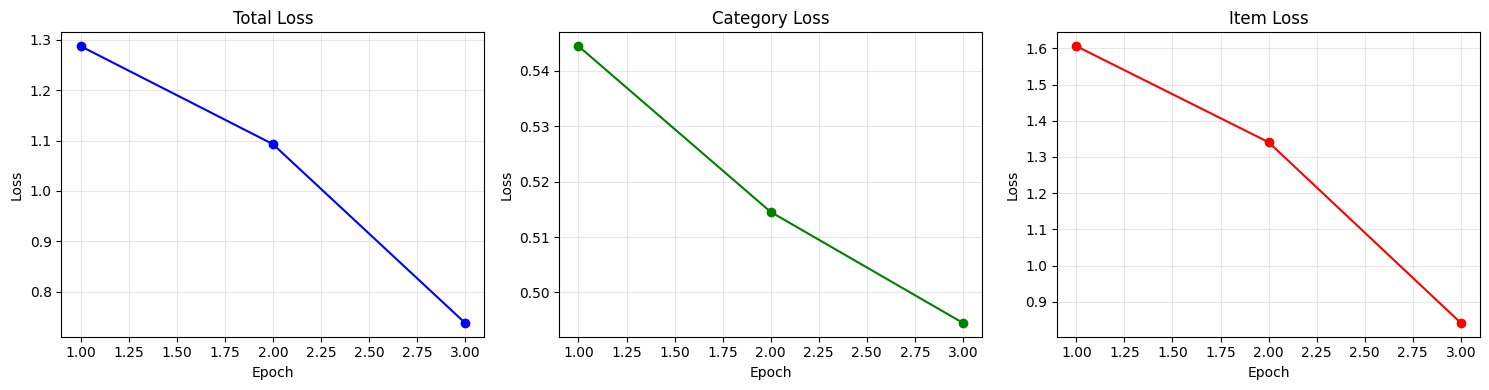

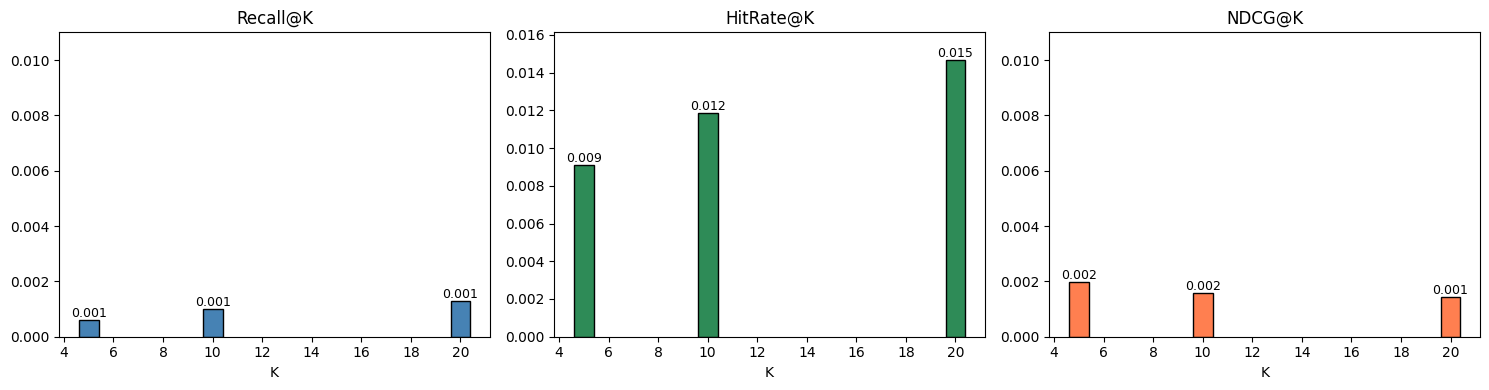

Saved plots to sampled_data/tdm_usersplit_loss.png and tdm_usersplit_eval.png


In [40]:
# 9) 训练与评估可视化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
epochs = [h['epoch'] for h in history_losses] if history_losses else []
axes[0].plot(epochs, [h['loss'] for h in history_losses], 'b-o')
axes[0].set_title('Total Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs, [h['cat_loss'] for h in history_losses], 'g-o')
axes[1].set_title('Category Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].grid(True, alpha=0.3)

axes[2].plot(epochs, [h['item_loss'] for h in history_losses], 'r-o')
axes[2].set_title('Item Loss')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'tdm_usersplit_loss.png'), dpi=150, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
k_values = [5, 10, 20]
bars = ['Recall', 'HitRate', 'NDCG']
for i, metric in enumerate(bars):
    vals = [eval_results.get(f'{metric}@{k}', 0) for k in k_values]
    ax[i].bar(k_values, vals, color=['steelblue', 'seagreen', 'coral'][i%3], edgecolor='black')
    ax[i].set_title(f'{metric}@K')
    ax[i].set_xlabel('K')
    ax[i].set_ylim(0, max(vals + [0.01]) * 1.1)
    for k, v in zip(k_values, vals):
        ax[i].text(k, v, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'tdm_usersplit_eval.png'), dpi=150, bbox_inches='tight')
plt.show()

print('Saved plots to sampled_data/tdm_usersplit_loss.png and tdm_usersplit_eval.png')